## All RBF Layers in one Class

In [2]:
import tensorflow as tf
import numpy as np
import gzip
import keras
import matplotlib.pyplot as plt
import time
import random
from sklearn.gaussian_process.kernels import PairwiseKernel
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.gaussian_process import GaussianProcessRegressor
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop, Adam, Nadam

Using TensorFlow backend.


In [3]:
np.set_printoptions(suppress=True)
np.set_printoptions(precision=3)

# read data set
f = gzip.open('./data/train-images-idx3-ubyte.gz', 'rb')
x_train = np.array(np.frombuffer(f.read(), np.uint8, offset=16))

f = gzip.open('./data/train-labels-idx1-ubyte.gz', 'rb')
y_train = np.array(np.frombuffer(f.read(), np.uint8, offset=8))

f = gzip.open('./data/t10k-images-idx3-ubyte.gz', 'rb')
x_test = np.array(np.frombuffer(f.read(), np.uint8, offset=16))

f = gzip.open('./data/t10k-labels-idx1-ubyte.gz', 'rb')
y_test = np.array(np.frombuffer(f.read(), np.uint8, offset=8))

# data preprocessing
x_train = np.reshape(x_train, (-1, 784))
x_train = x_train / 255
x_train = x_train.astype(np.float32)
x_test = np.reshape(x_test, (-1, 784))
x_test = x_test / 255
x_test = x_test.astype(np.float32)

# get each training images
idx_train = [0 for i in range(10)]
idx_test = [0 for i in range(10)]
for i in range(10):
    idx_train[i] = (y_train == i)
    idx_test[i] = (y_test == i)
      
x_train_38 = x_train[idx_train[3]+idx_train[8]]
x_test_38 = x_test[idx_test[3]+idx_test[8]]


# y_train_38 = y_train[idx_train[3]+idx_train[8]][0:1000]
# print(np.count_nonzero(y_train_38[y_train_38==3]))

# one-hot encoding
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

y_train_38 = y_train[idx_train[3]+idx_train[8]]
y_test_38 = y_test[idx_test[3]+idx_test[8]]


In [4]:
# K-Means clustering to find centers
_38 = []
for i in [3,8]:
    kmeans_model = KMeans(10)
    kmeans_model.fit(x_train[idx_train[i]])
    _38.extend(kmeans_model.cluster_centers_)

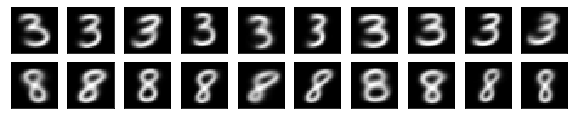

In [5]:
# plot cluster centers as images
fig = plt.figure(figsize = (10,10))

for i in range(20):
  subplot = fig.add_subplot(10, 10, i+1)
  subplot.set_xticks([])
  subplot.set_yticks([])
  subplot.imshow(np.reshape(_38[i]*255, (28, 28)), cmap='gray')
  

In [ ]:

class Model:
    
    def __init__(self):
        self.m_centers = []
        self.unit = None
        self.row = None
        self.col = None
        self.x = None
        
        self.m_train_image = []
        self.m_test_image = []
        self.m_train_label = []
        self.m_test_label = []
        
        self.temp1 = None
        self.temp2 = None
        self.model = None
        
    def _Segmentation(self,unit,centers, seg_num):
        self.unit = unit
        
        self.row = [random.randrange(0,29-self.unit) for i in range(seg_num)]
        self.col = [random.randrange(0,29-self.unit) for i in range(seg_num)]
        
        for i in range(seg_num):
            for center in centers:
                self.m_centers.extend(center[r*28+self.col[i] : r*28+(self.col[i]+self.unit) ] 
                                      for r in range(self.row[i],self.row[i]+self.unit))
                
        self.m_centers = np.reshape(self.m_centers,(-1,self.unit*self.unit))
        
        self.x = np.zeros((len(centers)*seg_num,len(centers)*seg_num))
        for i in range(len(centers)*seg_num):
            self.x[i][i] = 1
        
    def _fit(self,train_image,test_image,train_label,test_label):
        
        for i in range(len(self.row)):
            for arr in train_image:
                self.m_train_image.extend(arr[r*28+self.col[i] : r*28+(self.col[i]+self.unit) ] 
                                          for r in range(self.row[i],self.row[i]+self.unit))


            for arr in test_image:
                self.m_test_image.extend(arr[r*28+self.col[i] : r*28+(self.col[i]+self.unit) ] 
                                          for r in range(self.row[i],self.row[i]+self.unit))          

            for arr in train_label:    
                self.m_train_label.extend(arr)
                
            for arr in test_label:    
                self.m_test_label.extend(arr)
            
        self.m_train_image = np.reshape(self.m_train_image,(-1,self.unit*self.unit))    
        self.m_test_image = np.reshape(self.m_test_image,(-1,self.unit*self.unit))   
        self.m_train_label = np.reshape(self.m_train_label,(-1,10))
        self.m_test_label = np.reshape(self.m_test_label,(-1,10))
            
    
    def _RBF(self):
        # RBF Layer
        kernel = PairwiseKernel(metric='polynomial') 
        rbf_models = GaussianProcessRegressor(kernel=kernel,alpha=0.1).fit(self.m_centers, self.x)

        self.temp1=(rbf_models.predict(self.m_train_image))
        self.temp2=(rbf_models.predict(self.m_test_image))

    def _Train(self):
        batch_size = 128
        epochs = 100

        self.model = Sequential()
        self.model.add(Dense(10, activation='softmax', input_shape=(len(self.x),)))
        

        self.model.summary()
        nadam=keras.optimizers.Nadam(lr=0.0005)
        self.model.compile(loss='categorical_crossentropy',optimizer=nadam,metrics=['accuracy'])
        
        history = self.model.fit(self.temp1, self.m_train_label
                                 ,batch_size=batch_size
                                 ,epochs=epochs
                                 ,verbose=1)
        
    def _Predict(self):
        score = self.model.evaluate(self.temp2, self.m_test_label, verbose=0)
        print('Test loss:', score[0])
        print('Test accuracy:', score[1])


In [7]:
unit = 14
seg_num = 20
model = Model()
model._Segmentation(unit,_38,seg_num)
model._fit(x_train_38,x_test_38,y_train_38,y_test_38)
model._RBF()

print(model.m_train_label.shape)
print(model.m_train_image.shape)
print(model.temp1.shape)

(239640, 10)
(239640, 196)
(239640, 400)


In [8]:
model._Train()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                4010      
Total params: 4,010
Trainable params: 4,010
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
239640/239640 [==============================] - 8s 32us/step - loss: 1.1878 - acc: 0.6518
Epoch 2/100
239640/239640 [==============================] - 3s 14us/step - loss: 0.6356 - acc: 0.8150
Epoch 3/100
239640/239640 [==============================] - 3s 14us/step - loss: 0.4911 - acc: 0.8497
Epoch 4/100
239640/239640 [==============================] - 3s 14us/step - loss: 0.4250 - acc: 0.8636
Epoch 5/100
239640/239640 [==============================] - 3s 14us/step - loss: 0.3888 - acc: 0.8714
Epoch 6/100
239640/239640 [==============================] - 3s 14us/step - loss: 0.3663 - acc: 0.8762
Epoch 7/100
239640/239640 [=======================

In [9]:
model._Predict()

Test loss: 0.26677518271842987
Test accuracy: 0.9031502016129033
